In [9]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
from sklearn import preprocessing
import numpy as np
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
tf.random.set_seed(13)
pd.options.display.max_rows = 8


import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, RepeatVector,TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
import numpy as np
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, Callback

np.random.seed(4)
#from tensorflow import set_random_seed
tf.random.set_seed(4)
#from util import csv_to_dataset, history_points


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
##SADA
csv_path="MSFT_daily.csv"
data = pd.read_csv(csv_path)
data.columns="date open high low close volume".split()
col='open'
data[f'{col}_diff1'] = data[col] - data[col].shift(1)
data.dropna(inplace=True)

n1 = int(len(data) * .9)
X  = data[data.columns[1:-1]]
y  = data[data.columns[-1:]]

Xtrn = X[:n1]  # Training set
ytrn = y[:n1]  # Training y

standardScaler = 0
if (standardScaler):
    scalerX = preprocessing.StandardScaler()
    scalerY = preprocessing.StandardScaler()
else:
    scalerX = preprocessing.MinMaxScaler()
    scalerY = preprocessing.MinMaxScaler()

scalerX  = scalerX.fit(Xtrn)
scalerY  = scalerY.fit(ytrn)

X  = scalerX.transform(X)
y  = scalerY.transform(y)


Xtrn = X[:n1]  # Training set
ytrn = y[:n1]  # Training y
Xtst = X[n1:]  # Test predictors
ytst = y[n1:]  # trainig y
data

,date,open,high,low,close,volume,open_diff1
1,2000-02-29,91.75,91.75,88.8700,89.37,29218700.0,1.50
2,2000-03-01,89.62,94.09,88.9400,90.81,53444900.0,-2.13
3,2000-03-02,91.81,95.37,91.1200,93.37,53466300.0,2.19
4,2000-03-03,94.75,98.87,93.8700,96.12,50717600.0,2.94
...,...,...,...,...,...,...,...
5029,2020-02-25,174.20,174.84,167.6462,168.07,68073295.0,6.43
5030,2020-02-26,169.71,173.26,168.2100,170.17,56387148.0,-4.49
5031,2020-02-27,163.32,167.03,157.9800,158.18,93174906.0,-6.39
5032,2020-02-28,152.41,163.71,152.0000,162.01,96388312.0,-10.91


In [5]:
Xtrn, len(Xtrn), len(Xtst)

(array([[0.78577294, 0.76604951, 0.78149752, 0.76736973, 0.03993138],
        [0.76390885, 0.78959549, 0.78223677, 0.78225806, 0.08132944],
        [0.78638883, 0.80247535, 0.80525927, 0.80872622, 0.081366  ],
        ...,
        [0.79603777, 0.78939424, 0.81835463, 0.81586022, 0.03405521],
        [0.81297475, 0.80328034, 0.8383145 , 0.82992142, 0.04085683],
        [0.82672962, 0.80720467, 0.83778646, 0.81730769, 0.03364646]]),
 4528,
 504)

In [6]:
history_points=50
tsParams1 = {'length': history_points, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1, "shuffle":0 }
tsParams2 = {'length': history_points, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1, "shuffle":0 }

trng1 = TimeseriesGenerator(Xtrn, ytrn, **tsParams1 )
valg1 = TimeseriesGenerator(Xtst, ytst, **tsParams1 )
valg2 = TimeseriesGenerator(Xtst, ytst, **tsParams2 )

In [17]:
def getmodel1(nfeatures):
    lstm_input = Input(shape=(history_points, nfeatures), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(1, name='dense_1')(x)
    output = Activation('linear', name='linear_output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    
    return model

def getmodel2(nfeatures, nout, history_points):
    model1=None      

    #sensN = len(self.train_transformed[0].columns)  # number of sensors (eliminating the two time ones)
    #outN = len(self.num_id_list) # number of output sensors; the non-categorical ones        

    lookBack   = history_points
    nFeatures  = nfeatures  # Number of features 
    lstm_OPDim = nout       # This is usually all sensors except categorical that to train LSTM on
    lstm_IPDim = 256
    drop       = 0.3
    optimizer  = optimizers.Adam(lr=0.0005)
    loss       = 'mse'
    k_rrizer   = None
    r_rrizer   = None

    input_layer  = Input(shape=(lookBack, nFeatures), dtype='float32', name='input')
    memory_layer = LSTM( lstm_IPDim, return_sequences=True, name="memory1")(input_layer)
    memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=False, name="memory2")(memory_layer)
    repeated     = RepeatVector(lookBack)(memory_layer)
    memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=True, name="first1out")(repeated)
    memory_layer = LSTM (lstm_IPDim,  return_sequences=True, name="first2out")(memory_layer)
    decoded_inputs = TimeDistributed(Dense(units=lstm_OPDim, activation='linear'))( memory_layer)

    #  Try spatial dropout?
    dropout_input = Dropout(drop)(input_layer)
    concat_layer  = concatenate([dropout_input, decoded_inputs])

    #memory_layer = LSTM (units=self.lstm_dim, return_sequences=False)(concat_layer)
    memory_layer = LSTM (units=lstm_IPDim, 
                             kernel_regularizer = k_rrizer, 
                             recurrent_regularizer = r_rrizer, 
                             return_sequences=False)(concat_layer)
    preds = Dense(units=lstm_OPDim, activation='linear')(memory_layer)

    model1 = Model(input_layer, preds)
    model1.compile(optimizer = optimizer, loss= loss)             

    print(model1.summary())
    return model1


#model_1 = getmodel1(Xtrn.shape[-1])
model_1 = getmodel2(Xtrn.shape[-1], 1, history_points)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 5)        0                                            
__________________________________________________________________________________________________
memory1 (LSTM)                  (None, 50, 256)      268288      input[0][0]                      
__________________________________________________________________________________________________
memory2 (LSTM)                  (None, 128)          197120      memory1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 50, 128)      0           memory2[0][0]                    
____________________________________________________________________________________________

In [28]:
ep=20
vv=1
if ("cp" not in globals()):
    print("Creating the ModelCheckpoint")
    cp = ModelCheckpoint(filepath="simple2-2.h5", monitor='val_loss', save_best_only=True, verbose=1)
    
    dd='/opt/LMCO/git/notebooks/no-git/NNBook/notebooks/NNetworks/LSTM/new'
    if ( os.path.exist(f'{dd}/simple2-2.h5')):
        model_1 = load_model(f'{dd}/simple2-2.h5')
        cp.best = 1.4190391084412113e-09; #This was the best we saw
    
model_1.fit(trng1, verbose=vv, epochs=ep, validation_data=valg1,steps_per_epoch=200, shuffle=True, validation_steps=50,
               callbacks=[cp])
cp.best

Epoch 1/20
200/200 [==============================] - 17s 86ms/step - loss: 0.0010 - val_loss: 0.0074

Epoch 00001: val_loss did not improve from 0.0000226
Epoch 2/20
200/200 [==============================] - 17s 86ms/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00002: val_loss did not improve from 0.0000226
Epoch 3/20
200/200 [==============================] - 19s 94ms/step - loss: 9.4483e-04 - val_loss: 2.1947e-04

Epoch 00003: val_loss did not improve from 0.0000226
Epoch 4/20
200/200 [==============================] - 20s 99ms/step - loss: 0.0012 - val_loss: 3.3227e-04

Epoch 00004: val_loss did not improve from 0.0000226
Epoch 5/20
200/200 [==============================] - 19s 95ms/step - loss: 8.7474e-04 - val_loss: 4.7666e-04

Epoch 00005: val_loss did not improve from 0.0000226
Epoch 6/20
200/200 [==============================] - 19s 96ms/step - loss: 9.7537e-04 - val_loss: 0.0226

Epoch 00006: val_loss did not improve from 0.0000226
Epoch 7/20
200/200 [====================

9.878152695819153e-08

In [29]:
def plot(model, valg, n=-150, howmany=50):
    dd='/opt/LMCO/git/notebooks/no-git/NNBook/notebooks/NNetworks/LSTM/new'
    m1 = load_model(f'{dd}/simple2-{model}.h5')
    
    xxt = np.array([valg[i][0][0] for i in range(len(valg))])
    yyt = np.array([valg[i][1][0] for i in range(len(valg))])

    plt.gcf().set_size_inches(22, 10, forward=True)
    yh=m1.predict(xxt)
    plt.plot(yyt[n:n+howmany], marker='o', label="original")
    plt.plot( yh[n:n+howmany], marker='x', label="predicted")
    plt.title(f"{model} <==")
    plt.legend()
    plt.show()
    
    return yyt, yh
    

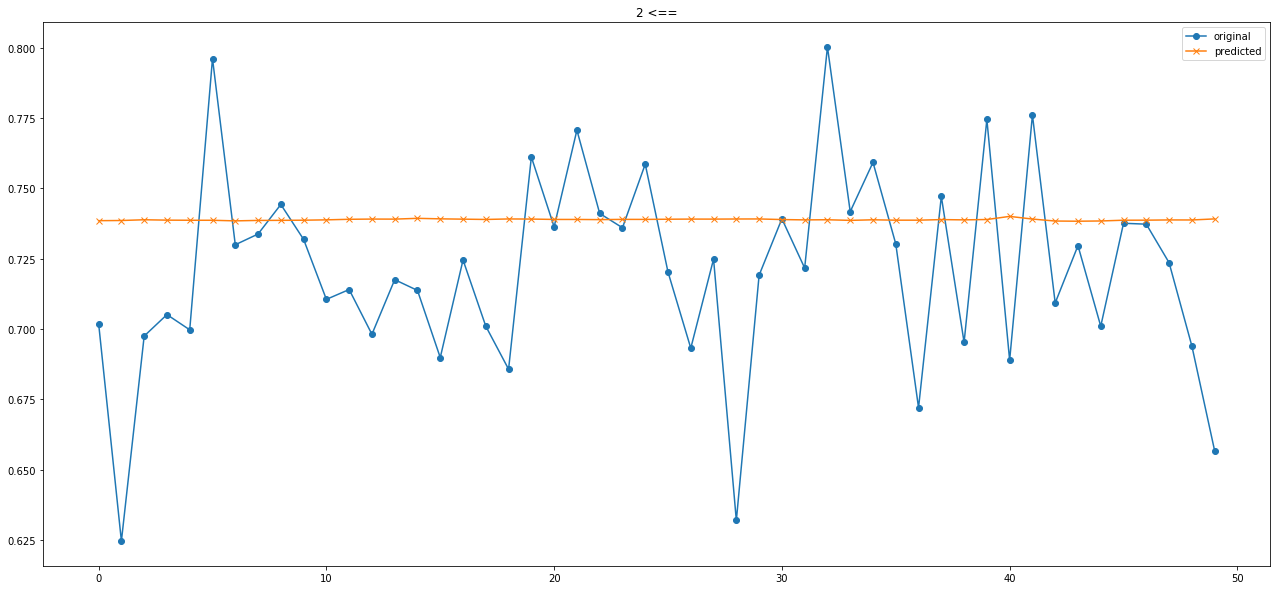

In [36]:
yo, yh = plot(2, valg2,-400,50);

In [31]:
# yoo = scalerY.inverse_transform(yo)
yho = scalerY.inverse_transform(yh)
yo1 = data[data.columns[-1]][-500:].values # <= original 

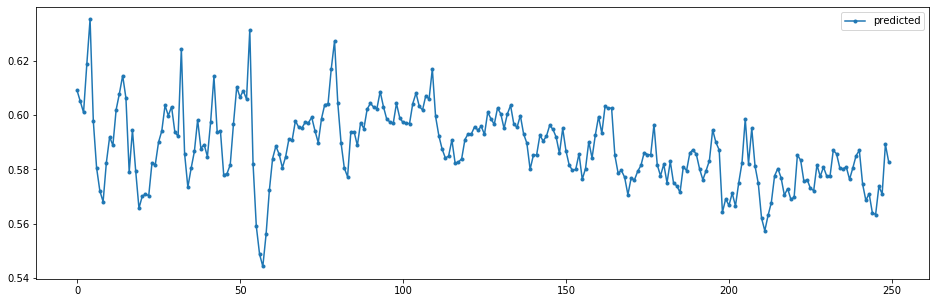

In [34]:
fr,hm=-350, 250
#plt.plot(yo1[fr:fr+hm]    , marker='o', label="original")
#plt.plot(yoo[fr:fr+hm]+0.1, marker='x', label = "used for computing validation error")
plt.plot(yho[fr:fr+hm]    , marker='.', label = "predicted")
plt.legend()

''

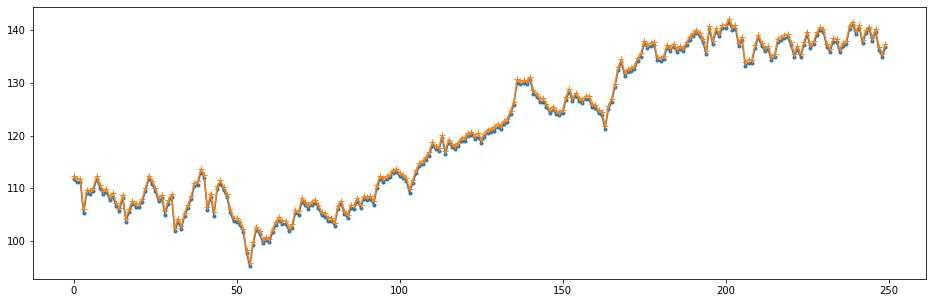

In [35]:
oopen = data['open'].values[-len(yho)-1:]# <= original 
popen = oopen[1:] + yho.flatten()

plt.plot(oopen[fr:fr+hm], marker='.', label="original")
plt.plot(popen[fr:fr+hm], marker='+', label = "used for computing validation error")
;